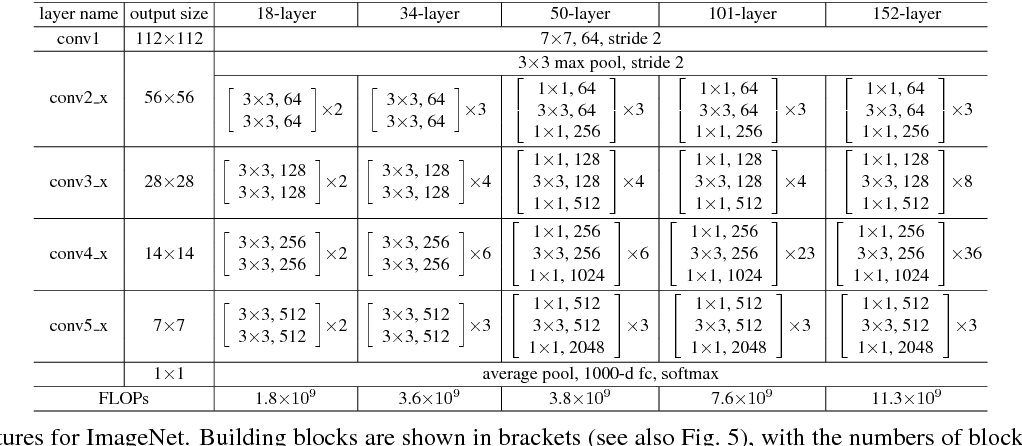

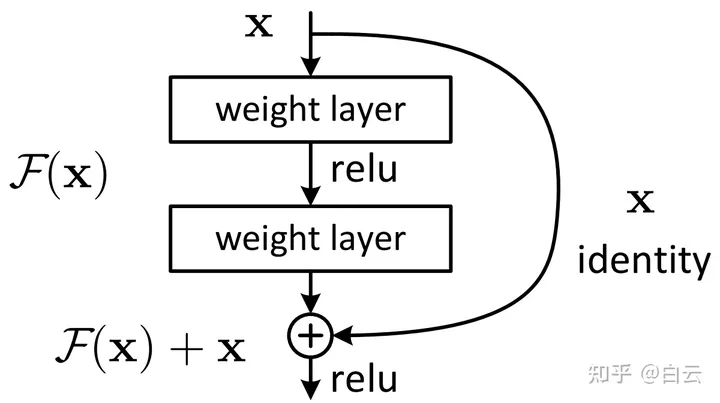

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:

# # 定义基本的Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        
        return out


In [9]:

# 定义ResNet18模型
class ResNet18(nn.Module):
    def __init__(self, ResidualBlock=ResidualBlock, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResidualBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(ResidualBlock, 256, 2, stride=2)        
        self.layer4 = self._make_layer(ResidualBlock, 512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1) # 将卷积层的输出转换为适应全连接层的输入形状
        out = self.fc(out)
        return out

In [4]:
resnet18_model = ResNet18(ResidualBlock, 5)

In [5]:
resnet18_model

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [6]:
#Use the ResNet18 on Cifar-10
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import os

#check gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#set hyperparameter
EPOCH = 30
pre_epoch = 10
BATCH_SIZE = 128
LR = 0.01

#prepare dataset and preprocessing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # 随机裁剪
    transforms.RandomHorizontalFlip(),#随机水平翻转
    transforms.ToTensor(), #将图像转换为 PyTorch 的张量
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


In [7]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

#labels in CIFAR10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

1.9%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

4.9%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

7.6%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

10.5%IOPub me

69.3%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

73.3%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

76.5%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

80.2%IOPub

In [14]:
# print(trainset[0])

(tensor([[[-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         ...,
         [-2.4291, -2.4291, -2.4291,  ...,  0.3430,  0.0910,  0.1297],
         [-2.4291, -2.4291, -2.4291,  ...,  0.4593,  0.2267,  0.3430],
         [-2.4291, -2.4291, -2.4291,  ...,  0.4205,  0.0328, -0.2192]],

        [[-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         ...,
         [-2.4183, -2.4183, -2.4183,  ..., -0.3532, -0.5892, -0.6482],
         [-2.4183, -2.4183, -2.4183,  ..., -0.2746, -0.4319, -0.3139],
         [-2.4183, -2.4183, -2.4183,  ..., -0.2156, -0.4319, -0.7072]],

        [[-2.2214, -2.2214, -2.2214,  ..., -2.2214, -2.2214, -2.2214],
         [-2.2214, -2.2214, -2.2214,  ..., -

In [10]:

#define ResNet18
net = ResNet18().to(device)

#define loss funtion & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)

In [19]:
for i, data in enumerate(trainloader, 0):
    length = len(trainloader)
    inputs, labels = data
    

In [29]:
print(length)
print(len(labels))
print(inputs.shape)
print(data[0].shape)

391
80
torch.Size([80, 3, 32, 32])
torch.Size([80, 3, 32, 32])


In [15]:
#train
for epoch in range(pre_epoch, EPOCH):
    print('\nEpoch: %d' % (epoch + 1))
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0
    for i, data in enumerate(trainloader, 0):
        #prepare dataset
        length = len(trainloader)    
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        #forward & backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print ac & loss in each batch
        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        print('[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% ' 
              % (epoch + 1, (i + 1 + epoch * length), sum_loss / (i + 1), 100. * correct / total))
        
    #get the ac with testdataset in each epoch
    print('Waiting Test...')
    with torch.no_grad():
        correct = 0
        total = 0
        for data in testloader:
            net.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        print('Test\'s ac is: %.3f%%' % (100 * correct / total))

print('Train has finished, total epoch is %d' % EPOCH)


Epoch: 1
[epoch:1, iter:1] Loss: 2.454 | Acc: 10.938% 
[epoch:1, iter:2] Loss: 2.455 | Acc: 11.328% 
[epoch:1, iter:3] Loss: 2.411 | Acc: 13.542% 
[epoch:1, iter:4] Loss: 2.374 | Acc: 14.648% 
[epoch:1, iter:5] Loss: 2.362 | Acc: 15.156% 
[epoch:1, iter:6] Loss: 2.344 | Acc: 15.755% 
[epoch:1, iter:7] Loss: 2.307 | Acc: 17.522% 
[epoch:1, iter:8] Loss: 2.283 | Acc: 18.262% 
[epoch:1, iter:9] Loss: 2.275 | Acc: 18.837% 
[epoch:1, iter:10] Loss: 2.280 | Acc: 19.922% 
[epoch:1, iter:11] Loss: 2.267 | Acc: 20.241% 
[epoch:1, iter:12] Loss: 2.275 | Acc: 20.898% 
[epoch:1, iter:13] Loss: 2.263 | Acc: 21.094% 
[epoch:1, iter:14] Loss: 2.273 | Acc: 20.815% 
[epoch:1, iter:15] Loss: 2.269 | Acc: 21.094% 
[epoch:1, iter:16] Loss: 2.246 | Acc: 21.582% 
[epoch:1, iter:17] Loss: 2.244 | Acc: 21.645% 
[epoch:1, iter:18] Loss: 2.245 | Acc: 21.441% 
[epoch:1, iter:19] Loss: 2.243 | Acc: 21.423% 
[epoch:1, iter:20] Loss: 2.241 | Acc: 21.328% 
[epoch:1, iter:21] Loss: 2.232 | Acc: 21.615% 
[epoch:1, it

[epoch:1, iter:174] Loss: 1.820 | Acc: 34.384% 
[epoch:1, iter:175] Loss: 1.818 | Acc: 34.429% 
[epoch:1, iter:176] Loss: 1.817 | Acc: 34.517% 
[epoch:1, iter:177] Loss: 1.815 | Acc: 34.609% 
[epoch:1, iter:178] Loss: 1.813 | Acc: 34.647% 
[epoch:1, iter:179] Loss: 1.813 | Acc: 34.663% 
[epoch:1, iter:180] Loss: 1.812 | Acc: 34.692% 
[epoch:1, iter:181] Loss: 1.811 | Acc: 34.716% 
[epoch:1, iter:182] Loss: 1.808 | Acc: 34.821% 
[epoch:1, iter:183] Loss: 1.806 | Acc: 34.845% 
[epoch:1, iter:184] Loss: 1.805 | Acc: 34.935% 
[epoch:1, iter:185] Loss: 1.803 | Acc: 35.000% 
[epoch:1, iter:186] Loss: 1.802 | Acc: 35.034% 
[epoch:1, iter:187] Loss: 1.802 | Acc: 35.052% 
[epoch:1, iter:188] Loss: 1.802 | Acc: 35.065% 
[epoch:1, iter:189] Loss: 1.801 | Acc: 35.090% 
[epoch:1, iter:190] Loss: 1.799 | Acc: 35.152% 
[epoch:1, iter:191] Loss: 1.798 | Acc: 35.193% 
[epoch:1, iter:192] Loss: 1.797 | Acc: 35.217% 
[epoch:1, iter:193] Loss: 1.795 | Acc: 35.298% 
[epoch:1, iter:194] Loss: 1.794 | Acc: 3

[epoch:1, iter:350] Loss: 1.671 | Acc: 40.000% 
[epoch:1, iter:351] Loss: 1.670 | Acc: 40.022% 
[epoch:1, iter:352] Loss: 1.669 | Acc: 40.057% 
[epoch:1, iter:353] Loss: 1.669 | Acc: 40.092% 
[epoch:1, iter:354] Loss: 1.668 | Acc: 40.113% 
[epoch:1, iter:355] Loss: 1.668 | Acc: 40.145% 
[epoch:1, iter:356] Loss: 1.667 | Acc: 40.173% 
[epoch:1, iter:357] Loss: 1.666 | Acc: 40.194% 
[epoch:1, iter:358] Loss: 1.665 | Acc: 40.213% 
[epoch:1, iter:359] Loss: 1.664 | Acc: 40.244% 
[epoch:1, iter:360] Loss: 1.663 | Acc: 40.278% 
[epoch:1, iter:361] Loss: 1.663 | Acc: 40.311% 
[epoch:1, iter:362] Loss: 1.662 | Acc: 40.331% 
[epoch:1, iter:363] Loss: 1.660 | Acc: 40.375% 
[epoch:1, iter:364] Loss: 1.660 | Acc: 40.402% 
[epoch:1, iter:365] Loss: 1.659 | Acc: 40.407% 
[epoch:1, iter:366] Loss: 1.659 | Acc: 40.429% 
[epoch:1, iter:367] Loss: 1.658 | Acc: 40.453% 
[epoch:1, iter:368] Loss: 1.657 | Acc: 40.481% 
[epoch:1, iter:369] Loss: 1.656 | Acc: 40.515% 
[epoch:1, iter:370] Loss: 1.655 | Acc: 4

[epoch:2, iter:526] Loss: 1.332 | Acc: 52.870% 
[epoch:2, iter:527] Loss: 1.333 | Acc: 52.844% 
[epoch:2, iter:528] Loss: 1.333 | Acc: 52.840% 
[epoch:2, iter:529] Loss: 1.333 | Acc: 52.853% 
[epoch:2, iter:530] Loss: 1.333 | Acc: 52.850% 
[epoch:2, iter:531] Loss: 1.333 | Acc: 52.829% 
[epoch:2, iter:532] Loss: 1.332 | Acc: 52.865% 
[epoch:2, iter:533] Loss: 1.332 | Acc: 52.861% 
[epoch:2, iter:534] Loss: 1.331 | Acc: 52.868% 
[epoch:2, iter:535] Loss: 1.330 | Acc: 52.941% 
[epoch:2, iter:536] Loss: 1.329 | Acc: 52.931% 
[epoch:2, iter:537] Loss: 1.329 | Acc: 52.954% 
[epoch:2, iter:538] Loss: 1.328 | Acc: 52.976% 
[epoch:2, iter:539] Loss: 1.327 | Acc: 52.967% 
[epoch:2, iter:540] Loss: 1.327 | Acc: 53.004% 
[epoch:2, iter:541] Loss: 1.328 | Acc: 53.000% 
[epoch:2, iter:542] Loss: 1.328 | Acc: 53.001% 
[epoch:2, iter:543] Loss: 1.329 | Acc: 52.955% 
[epoch:2, iter:544] Loss: 1.330 | Acc: 52.911% 
[epoch:2, iter:545] Loss: 1.330 | Acc: 52.887% 
[epoch:2, iter:546] Loss: 1.329 | Acc: 5

[epoch:2, iter:702] Loss: 1.276 | Acc: 54.911% 
[epoch:2, iter:703] Loss: 1.275 | Acc: 54.915% 
[epoch:2, iter:704] Loss: 1.275 | Acc: 54.927% 
[epoch:2, iter:705] Loss: 1.274 | Acc: 54.954% 
[epoch:2, iter:706] Loss: 1.273 | Acc: 54.975% 
[epoch:2, iter:707] Loss: 1.273 | Acc: 54.989% 
[epoch:2, iter:708] Loss: 1.273 | Acc: 54.978% 
[epoch:2, iter:709] Loss: 1.273 | Acc: 54.977% 
[epoch:2, iter:710] Loss: 1.272 | Acc: 54.991% 
[epoch:2, iter:711] Loss: 1.272 | Acc: 55.010% 
[epoch:2, iter:712] Loss: 1.272 | Acc: 55.014% 
[epoch:2, iter:713] Loss: 1.273 | Acc: 54.981% 
[epoch:2, iter:714] Loss: 1.273 | Acc: 54.985% 
[epoch:2, iter:715] Loss: 1.273 | Acc: 54.986% 
[epoch:2, iter:716] Loss: 1.273 | Acc: 55.000% 
[epoch:2, iter:717] Loss: 1.272 | Acc: 55.028% 
[epoch:2, iter:718] Loss: 1.272 | Acc: 55.039% 
[epoch:2, iter:719] Loss: 1.271 | Acc: 55.061% 
[epoch:2, iter:720] Loss: 1.271 | Acc: 55.067% 
[epoch:2, iter:721] Loss: 1.271 | Acc: 55.057% 
[epoch:2, iter:722] Loss: 1.271 | Acc: 5

[epoch:3, iter:877] Loss: 1.102 | Acc: 61.266% 
[epoch:3, iter:878] Loss: 1.104 | Acc: 61.198% 
[epoch:3, iter:879] Loss: 1.103 | Acc: 61.203% 
[epoch:3, iter:880] Loss: 1.104 | Acc: 61.177% 
[epoch:3, iter:881] Loss: 1.105 | Acc: 61.135% 
[epoch:3, iter:882] Loss: 1.106 | Acc: 61.078% 
[epoch:3, iter:883] Loss: 1.106 | Acc: 61.108% 
[epoch:3, iter:884] Loss: 1.107 | Acc: 61.091% 
[epoch:3, iter:885] Loss: 1.108 | Acc: 61.120% 
[epoch:3, iter:886] Loss: 1.106 | Acc: 61.170% 
[epoch:3, iter:887] Loss: 1.106 | Acc: 61.183% 
[epoch:3, iter:888] Loss: 1.105 | Acc: 61.188% 
[epoch:3, iter:889] Loss: 1.105 | Acc: 61.178% 
[epoch:3, iter:890] Loss: 1.108 | Acc: 61.089% 
[epoch:3, iter:891] Loss: 1.107 | Acc: 61.088% 
[epoch:3, iter:892] Loss: 1.107 | Acc: 61.058% 
[epoch:3, iter:893] Loss: 1.108 | Acc: 61.064% 
[epoch:3, iter:894] Loss: 1.109 | Acc: 61.042% 
[epoch:3, iter:895] Loss: 1.109 | Acc: 61.062% 
[epoch:3, iter:896] Loss: 1.109 | Acc: 61.040% 
[epoch:3, iter:897] Loss: 1.108 | Acc: 6

[epoch:3, iter:1053] Loss: 1.090 | Acc: 61.673% 
[epoch:3, iter:1054] Loss: 1.090 | Acc: 61.681% 
[epoch:3, iter:1055] Loss: 1.090 | Acc: 61.699% 
[epoch:3, iter:1056] Loss: 1.089 | Acc: 61.704% 
[epoch:3, iter:1057] Loss: 1.089 | Acc: 61.707% 
[epoch:3, iter:1058] Loss: 1.090 | Acc: 61.707% 
[epoch:3, iter:1059] Loss: 1.089 | Acc: 61.733% 
[epoch:3, iter:1060] Loss: 1.089 | Acc: 61.752% 
[epoch:3, iter:1061] Loss: 1.088 | Acc: 61.764% 
[epoch:3, iter:1062] Loss: 1.089 | Acc: 61.780% 
[epoch:3, iter:1063] Loss: 1.089 | Acc: 61.791% 
[epoch:3, iter:1064] Loss: 1.088 | Acc: 61.788% 
[epoch:3, iter:1065] Loss: 1.088 | Acc: 61.813% 
[epoch:3, iter:1066] Loss: 1.088 | Acc: 61.837% 
[epoch:3, iter:1067] Loss: 1.088 | Acc: 61.848% 
[epoch:3, iter:1068] Loss: 1.088 | Acc: 61.828% 
[epoch:3, iter:1069] Loss: 1.088 | Acc: 61.855% 
[epoch:3, iter:1070] Loss: 1.087 | Acc: 61.846% 
[epoch:3, iter:1071] Loss: 1.088 | Acc: 61.827% 
[epoch:3, iter:1072] Loss: 1.088 | Acc: 61.829% 
[epoch:3, iter:1073]

[epoch:4, iter:1227] Loss: 0.983 | Acc: 65.292% 
[epoch:4, iter:1228] Loss: 0.982 | Acc: 65.369% 
[epoch:4, iter:1229] Loss: 0.984 | Acc: 65.332% 
[epoch:4, iter:1230] Loss: 0.986 | Acc: 65.310% 
[epoch:4, iter:1231] Loss: 0.986 | Acc: 65.302% 
[epoch:4, iter:1232] Loss: 0.984 | Acc: 65.281% 
[epoch:4, iter:1233] Loss: 0.985 | Acc: 65.260% 
[epoch:4, iter:1234] Loss: 0.984 | Acc: 65.279% 
[epoch:4, iter:1235] Loss: 0.983 | Acc: 65.247% 
[epoch:4, iter:1236] Loss: 0.983 | Acc: 65.203% 
[epoch:4, iter:1237] Loss: 0.982 | Acc: 65.186% 
[epoch:4, iter:1238] Loss: 0.983 | Acc: 65.120% 
[epoch:4, iter:1239] Loss: 0.983 | Acc: 65.128% 
[epoch:4, iter:1240] Loss: 0.981 | Acc: 65.205% 
[epoch:4, iter:1241] Loss: 0.981 | Acc: 65.154% 
[epoch:4, iter:1242] Loss: 0.981 | Acc: 65.161% 
[epoch:4, iter:1243] Loss: 0.980 | Acc: 65.167% 
[epoch:4, iter:1244] Loss: 0.978 | Acc: 65.317% 
[epoch:4, iter:1245] Loss: 0.977 | Acc: 65.343% 
[epoch:4, iter:1246] Loss: 0.977 | Acc: 65.368% 
[epoch:4, iter:1247]

[epoch:4, iter:1395] Loss: 0.963 | Acc: 65.966% 
[epoch:4, iter:1396] Loss: 0.962 | Acc: 65.982% 
[epoch:4, iter:1397] Loss: 0.963 | Acc: 65.953% 
[epoch:4, iter:1398] Loss: 0.963 | Acc: 65.948% 
[epoch:4, iter:1399] Loss: 0.963 | Acc: 65.957% 
[epoch:4, iter:1400] Loss: 0.963 | Acc: 65.959% 
[epoch:4, iter:1401] Loss: 0.962 | Acc: 65.998% 
[epoch:4, iter:1402] Loss: 0.962 | Acc: 65.993% 
[epoch:4, iter:1403] Loss: 0.962 | Acc: 66.012% 
[epoch:4, iter:1404] Loss: 0.962 | Acc: 66.038% 
[epoch:4, iter:1405] Loss: 0.962 | Acc: 66.049% 
[epoch:4, iter:1406] Loss: 0.962 | Acc: 66.068% 
[epoch:4, iter:1407] Loss: 0.961 | Acc: 66.066% 
[epoch:4, iter:1408] Loss: 0.961 | Acc: 66.094% 
[epoch:4, iter:1409] Loss: 0.961 | Acc: 66.112% 
[epoch:4, iter:1410] Loss: 0.960 | Acc: 66.152% 
[epoch:4, iter:1411] Loss: 0.960 | Acc: 66.160% 
[epoch:4, iter:1412] Loss: 0.960 | Acc: 66.141% 
[epoch:4, iter:1413] Loss: 0.961 | Acc: 66.149% 
[epoch:4, iter:1414] Loss: 0.960 | Acc: 66.160% 
[epoch:4, iter:1415]

[epoch:4, iter:1563] Loss: 0.950 | Acc: 66.575% 
[epoch:4, iter:1564] Loss: 0.950 | Acc: 66.568% 
Waiting Test...
Test's ac is: 67.140%

Epoch: 5
[epoch:5, iter:1565] Loss: 0.859 | Acc: 71.875% 
[epoch:5, iter:1566] Loss: 0.836 | Acc: 72.266% 
[epoch:5, iter:1567] Loss: 0.843 | Acc: 71.094% 
[epoch:5, iter:1568] Loss: 0.898 | Acc: 69.336% 
[epoch:5, iter:1569] Loss: 0.929 | Acc: 67.969% 
[epoch:5, iter:1570] Loss: 0.938 | Acc: 67.578% 
[epoch:5, iter:1571] Loss: 0.922 | Acc: 68.527% 
[epoch:5, iter:1572] Loss: 0.909 | Acc: 69.043% 
[epoch:5, iter:1573] Loss: 0.916 | Acc: 68.663% 
[epoch:5, iter:1574] Loss: 0.915 | Acc: 68.672% 
[epoch:5, iter:1575] Loss: 0.892 | Acc: 69.247% 
[epoch:5, iter:1576] Loss: 0.883 | Acc: 69.792% 
[epoch:5, iter:1577] Loss: 0.887 | Acc: 69.351% 
[epoch:5, iter:1578] Loss: 0.896 | Acc: 68.973% 
[epoch:5, iter:1579] Loss: 0.889 | Acc: 69.167% 
[epoch:5, iter:1580] Loss: 0.882 | Acc: 69.434% 
[epoch:5, iter:1581] Loss: 0.877 | Acc: 69.761% 
[epoch:5, iter:1582] 

[epoch:5, iter:1731] Loss: 0.881 | Acc: 68.858% 
[epoch:5, iter:1732] Loss: 0.882 | Acc: 68.820% 
[epoch:5, iter:1733] Loss: 0.882 | Acc: 68.805% 
[epoch:5, iter:1734] Loss: 0.882 | Acc: 68.805% 
[epoch:5, iter:1735] Loss: 0.883 | Acc: 68.809% 
[epoch:5, iter:1736] Loss: 0.882 | Acc: 68.823% 
[epoch:5, iter:1737] Loss: 0.881 | Acc: 68.858% 
[epoch:5, iter:1738] Loss: 0.881 | Acc: 68.849% 
[epoch:5, iter:1739] Loss: 0.881 | Acc: 68.839% 
[epoch:5, iter:1740] Loss: 0.880 | Acc: 68.865% 
[epoch:5, iter:1741] Loss: 0.880 | Acc: 68.896% 
[epoch:5, iter:1742] Loss: 0.880 | Acc: 68.873% 
[epoch:5, iter:1743] Loss: 0.879 | Acc: 68.907% 
[epoch:5, iter:1744] Loss: 0.878 | Acc: 68.928% 
[epoch:5, iter:1745] Loss: 0.879 | Acc: 68.914% 
[epoch:5, iter:1746] Loss: 0.879 | Acc: 68.922% 
[epoch:5, iter:1747] Loss: 0.879 | Acc: 68.929% 
[epoch:5, iter:1748] Loss: 0.878 | Acc: 68.937% 
[epoch:5, iter:1749] Loss: 0.879 | Acc: 68.919% 
[epoch:5, iter:1750] Loss: 0.879 | Acc: 68.918% 
[epoch:5, iter:1751]

[epoch:5, iter:1899] Loss: 0.879 | Acc: 69.146% 
[epoch:5, iter:1900] Loss: 0.879 | Acc: 69.152% 
[epoch:5, iter:1901] Loss: 0.879 | Acc: 69.167% 
[epoch:5, iter:1902] Loss: 0.879 | Acc: 69.180% 
[epoch:5, iter:1903] Loss: 0.879 | Acc: 69.163% 
[epoch:5, iter:1904] Loss: 0.879 | Acc: 69.164% 
[epoch:5, iter:1905] Loss: 0.879 | Acc: 69.165% 
[epoch:5, iter:1906] Loss: 0.878 | Acc: 69.173% 
[epoch:5, iter:1907] Loss: 0.878 | Acc: 69.178% 
[epoch:5, iter:1908] Loss: 0.878 | Acc: 69.154% 
[epoch:5, iter:1909] Loss: 0.877 | Acc: 69.183% 
[epoch:5, iter:1910] Loss: 0.877 | Acc: 69.174% 
[epoch:5, iter:1911] Loss: 0.877 | Acc: 69.189% 
[epoch:5, iter:1912] Loss: 0.877 | Acc: 69.197% 
[epoch:5, iter:1913] Loss: 0.877 | Acc: 69.178% 
[epoch:5, iter:1914] Loss: 0.877 | Acc: 69.196% 
[epoch:5, iter:1915] Loss: 0.877 | Acc: 69.200% 
[epoch:5, iter:1916] Loss: 0.877 | Acc: 69.212% 
[epoch:5, iter:1917] Loss: 0.877 | Acc: 69.195% 
[epoch:5, iter:1918] Loss: 0.877 | Acc: 69.211% 
[epoch:5, iter:1919]

[epoch:6, iter:2066] Loss: 0.807 | Acc: 71.601% 
[epoch:6, iter:2067] Loss: 0.808 | Acc: 71.603% 
[epoch:6, iter:2068] Loss: 0.807 | Acc: 71.605% 
[epoch:6, iter:2069] Loss: 0.809 | Acc: 71.546% 
[epoch:6, iter:2070] Loss: 0.807 | Acc: 71.596% 
[epoch:6, iter:2071] Loss: 0.807 | Acc: 71.606% 
[epoch:6, iter:2072] Loss: 0.809 | Acc: 71.514% 
[epoch:6, iter:2073] Loss: 0.808 | Acc: 71.524% 
[epoch:6, iter:2074] Loss: 0.807 | Acc: 71.547% 
[epoch:6, iter:2075] Loss: 0.808 | Acc: 71.569% 
[epoch:6, iter:2076] Loss: 0.806 | Acc: 71.584% 
[epoch:6, iter:2077] Loss: 0.807 | Acc: 71.497% 
[epoch:6, iter:2078] Loss: 0.809 | Acc: 71.475% 
[epoch:6, iter:2079] Loss: 0.809 | Acc: 71.472% 
[epoch:6, iter:2080] Loss: 0.809 | Acc: 71.475% 
[epoch:6, iter:2081] Loss: 0.810 | Acc: 71.398% 
[epoch:6, iter:2082] Loss: 0.810 | Acc: 71.407% 
[epoch:6, iter:2083] Loss: 0.810 | Acc: 71.436% 
[epoch:6, iter:2084] Loss: 0.810 | Acc: 71.445% 
[epoch:6, iter:2085] Loss: 0.810 | Acc: 71.436% 
[epoch:6, iter:2086]

[epoch:6, iter:2241] Loss: 0.809 | Acc: 71.408% 
[epoch:6, iter:2242] Loss: 0.809 | Acc: 71.399% 
[epoch:6, iter:2243] Loss: 0.809 | Acc: 71.406% 
[epoch:6, iter:2244] Loss: 0.809 | Acc: 71.413% 
[epoch:6, iter:2245] Loss: 0.808 | Acc: 71.414% 
[epoch:6, iter:2246] Loss: 0.809 | Acc: 71.402% 
[epoch:6, iter:2247] Loss: 0.809 | Acc: 71.385% 
[epoch:6, iter:2248] Loss: 0.809 | Acc: 71.390% 
[epoch:6, iter:2249] Loss: 0.809 | Acc: 71.402% 
[epoch:6, iter:2250] Loss: 0.809 | Acc: 71.404% 
[epoch:6, iter:2251] Loss: 0.808 | Acc: 71.413% 
[epoch:6, iter:2252] Loss: 0.809 | Acc: 71.412% 
[epoch:6, iter:2253] Loss: 0.808 | Acc: 71.429% 
[epoch:6, iter:2254] Loss: 0.808 | Acc: 71.441% 
[epoch:6, iter:2255] Loss: 0.808 | Acc: 71.451% 
[epoch:6, iter:2256] Loss: 0.808 | Acc: 71.457% 
[epoch:6, iter:2257] Loss: 0.808 | Acc: 71.466% 
[epoch:6, iter:2258] Loss: 0.808 | Acc: 71.470% 
[epoch:6, iter:2259] Loss: 0.807 | Acc: 71.477% 
[epoch:6, iter:2260] Loss: 0.808 | Acc: 71.463% 
[epoch:6, iter:2261]

[epoch:7, iter:2408] Loss: 0.777 | Acc: 72.870% 
[epoch:7, iter:2409] Loss: 0.776 | Acc: 72.892% 
[epoch:7, iter:2410] Loss: 0.775 | Acc: 72.961% 
[epoch:7, iter:2411] Loss: 0.776 | Acc: 72.921% 
[epoch:7, iter:2412] Loss: 0.778 | Acc: 72.822% 
[epoch:7, iter:2413] Loss: 0.777 | Acc: 72.831% 
[epoch:7, iter:2414] Loss: 0.780 | Acc: 72.691% 
[epoch:7, iter:2415] Loss: 0.781 | Acc: 72.634% 
[epoch:7, iter:2416] Loss: 0.781 | Acc: 72.656% 
[epoch:7, iter:2417] Loss: 0.780 | Acc: 72.722% 
[epoch:7, iter:2418] Loss: 0.781 | Acc: 72.613% 
[epoch:7, iter:2419] Loss: 0.782 | Acc: 72.592% 
[epoch:7, iter:2420] Loss: 0.783 | Acc: 72.561% 
[epoch:7, iter:2421] Loss: 0.783 | Acc: 72.562% 
[epoch:7, iter:2422] Loss: 0.783 | Acc: 72.543% 
[epoch:7, iter:2423] Loss: 0.782 | Acc: 72.565% 
[epoch:7, iter:2424] Loss: 0.783 | Acc: 72.536% 
[epoch:7, iter:2425] Loss: 0.784 | Acc: 72.528% 
[epoch:7, iter:2426] Loss: 0.783 | Acc: 72.529% 
[epoch:7, iter:2427] Loss: 0.784 | Acc: 72.521% 
[epoch:7, iter:2428]

[epoch:7, iter:2576] Loss: 0.772 | Acc: 73.149% 
[epoch:7, iter:2577] Loss: 0.772 | Acc: 73.153% 
[epoch:7, iter:2578] Loss: 0.772 | Acc: 73.138% 
[epoch:7, iter:2579] Loss: 0.772 | Acc: 73.156% 
[epoch:7, iter:2580] Loss: 0.772 | Acc: 73.147% 
[epoch:7, iter:2581] Loss: 0.772 | Acc: 73.172% 
[epoch:7, iter:2582] Loss: 0.772 | Acc: 73.149% 
[epoch:7, iter:2583] Loss: 0.772 | Acc: 73.141% 
[epoch:7, iter:2584] Loss: 0.772 | Acc: 73.165% 
[epoch:7, iter:2585] Loss: 0.771 | Acc: 73.186% 
[epoch:7, iter:2586] Loss: 0.771 | Acc: 73.200% 
[epoch:7, iter:2587] Loss: 0.771 | Acc: 73.191% 
[epoch:7, iter:2588] Loss: 0.771 | Acc: 73.195% 
[epoch:7, iter:2589] Loss: 0.771 | Acc: 73.161% 
[epoch:7, iter:2590] Loss: 0.771 | Acc: 73.159% 
[epoch:7, iter:2591] Loss: 0.771 | Acc: 73.163% 
[epoch:7, iter:2592] Loss: 0.771 | Acc: 73.168% 
[epoch:7, iter:2593] Loss: 0.772 | Acc: 73.165% 
[epoch:7, iter:2594] Loss: 0.771 | Acc: 73.185% 
[epoch:7, iter:2595] Loss: 0.771 | Acc: 73.186% 
[epoch:7, iter:2596]

[epoch:8, iter:2744] Loss: 0.658 | Acc: 78.683% 
[epoch:8, iter:2745] Loss: 0.688 | Acc: 77.148% 
[epoch:8, iter:2746] Loss: 0.677 | Acc: 77.691% 
[epoch:8, iter:2747] Loss: 0.689 | Acc: 76.562% 
[epoch:8, iter:2748] Loss: 0.672 | Acc: 77.344% 
[epoch:8, iter:2749] Loss: 0.666 | Acc: 77.734% 
[epoch:8, iter:2750] Loss: 0.674 | Acc: 77.284% 
[epoch:8, iter:2751] Loss: 0.670 | Acc: 77.511% 
[epoch:8, iter:2752] Loss: 0.672 | Acc: 77.292% 
[epoch:8, iter:2753] Loss: 0.669 | Acc: 77.295% 
[epoch:8, iter:2754] Loss: 0.667 | Acc: 77.436% 
[epoch:8, iter:2755] Loss: 0.663 | Acc: 77.344% 
[epoch:8, iter:2756] Loss: 0.663 | Acc: 77.220% 
[epoch:8, iter:2757] Loss: 0.666 | Acc: 77.148% 
[epoch:8, iter:2758] Loss: 0.665 | Acc: 77.083% 
[epoch:8, iter:2759] Loss: 0.678 | Acc: 76.669% 
[epoch:8, iter:2760] Loss: 0.679 | Acc: 76.766% 
[epoch:8, iter:2761] Loss: 0.686 | Acc: 76.562% 
[epoch:8, iter:2762] Loss: 0.691 | Acc: 76.406% 
[epoch:8, iter:2763] Loss: 0.693 | Acc: 76.382% 
[epoch:8, iter:2764]

[epoch:8, iter:2918] Loss: 0.724 | Acc: 74.689% 
[epoch:8, iter:2919] Loss: 0.724 | Acc: 74.717% 
[epoch:8, iter:2920] Loss: 0.724 | Acc: 74.731% 
[epoch:8, iter:2921] Loss: 0.723 | Acc: 74.754% 
[epoch:8, iter:2922] Loss: 0.723 | Acc: 74.738% 
[epoch:8, iter:2923] Loss: 0.722 | Acc: 74.752% 
[epoch:8, iter:2924] Loss: 0.724 | Acc: 74.708% 
[epoch:8, iter:2925] Loss: 0.724 | Acc: 74.697% 
[epoch:8, iter:2926] Loss: 0.725 | Acc: 74.661% 
[epoch:8, iter:2927] Loss: 0.724 | Acc: 74.683% 
[epoch:8, iter:2928] Loss: 0.724 | Acc: 74.693% 
[epoch:8, iter:2929] Loss: 0.724 | Acc: 74.707% 
[epoch:8, iter:2930] Loss: 0.722 | Acc: 74.769% 
[epoch:8, iter:2931] Loss: 0.722 | Acc: 74.746% 
[epoch:8, iter:2932] Loss: 0.722 | Acc: 74.752% 
[epoch:8, iter:2933] Loss: 0.722 | Acc: 74.757% 
[epoch:8, iter:2934] Loss: 0.722 | Acc: 74.778% 
[epoch:8, iter:2935] Loss: 0.721 | Acc: 74.795% 
[epoch:8, iter:2936] Loss: 0.721 | Acc: 74.788% 
[epoch:8, iter:2937] Loss: 0.721 | Acc: 74.777% 
[epoch:8, iter:2938]

[epoch:8, iter:3086] Loss: 0.725 | Acc: 74.622% 
[epoch:8, iter:3087] Loss: 0.725 | Acc: 74.625% 
[epoch:8, iter:3088] Loss: 0.725 | Acc: 74.635% 
[epoch:8, iter:3089] Loss: 0.724 | Acc: 74.632% 
[epoch:8, iter:3090] Loss: 0.725 | Acc: 74.622% 
[epoch:8, iter:3091] Loss: 0.725 | Acc: 74.616% 
[epoch:8, iter:3092] Loss: 0.724 | Acc: 74.630% 
[epoch:8, iter:3093] Loss: 0.724 | Acc: 74.658% 
[epoch:8, iter:3094] Loss: 0.724 | Acc: 74.667% 
[epoch:8, iter:3095] Loss: 0.724 | Acc: 74.653% 
[epoch:8, iter:3096] Loss: 0.724 | Acc: 74.661% 
[epoch:8, iter:3097] Loss: 0.724 | Acc: 74.659% 
[epoch:8, iter:3098] Loss: 0.724 | Acc: 74.665% 
[epoch:8, iter:3099] Loss: 0.724 | Acc: 74.687% 
[epoch:8, iter:3100] Loss: 0.724 | Acc: 74.686% 
[epoch:8, iter:3101] Loss: 0.723 | Acc: 74.704% 
[epoch:8, iter:3102] Loss: 0.724 | Acc: 74.688% 
[epoch:8, iter:3103] Loss: 0.724 | Acc: 74.690% 
[epoch:8, iter:3104] Loss: 0.723 | Acc: 74.696% 
[epoch:8, iter:3105] Loss: 0.723 | Acc: 74.690% 
[epoch:8, iter:3106]

[epoch:9, iter:3255] Loss: 0.695 | Acc: 76.070% 
[epoch:9, iter:3256] Loss: 0.694 | Acc: 76.105% 
[epoch:9, iter:3257] Loss: 0.694 | Acc: 76.090% 
[epoch:9, iter:3258] Loss: 0.693 | Acc: 76.100% 
[epoch:9, iter:3259] Loss: 0.693 | Acc: 76.115% 
[epoch:9, iter:3260] Loss: 0.693 | Acc: 76.101% 
[epoch:9, iter:3261] Loss: 0.693 | Acc: 76.063% 
[epoch:9, iter:3262] Loss: 0.694 | Acc: 76.044% 
[epoch:9, iter:3263] Loss: 0.695 | Acc: 76.001% 
[epoch:9, iter:3264] Loss: 0.695 | Acc: 76.040% 
[epoch:9, iter:3265] Loss: 0.694 | Acc: 76.044% 
[epoch:9, iter:3266] Loss: 0.697 | Acc: 75.974% 
[epoch:9, iter:3267] Loss: 0.696 | Acc: 76.029% 
[epoch:9, iter:3268] Loss: 0.695 | Acc: 76.066% 
[epoch:9, iter:3269] Loss: 0.694 | Acc: 76.114% 
[epoch:9, iter:3270] Loss: 0.694 | Acc: 76.100% 
[epoch:9, iter:3271] Loss: 0.693 | Acc: 76.142% 
[epoch:9, iter:3272] Loss: 0.693 | Acc: 76.161% 
[epoch:9, iter:3273] Loss: 0.693 | Acc: 76.158% 
[epoch:9, iter:3274] Loss: 0.693 | Acc: 76.129% 
[epoch:9, iter:3275]

[epoch:9, iter:3423] Loss: 0.693 | Acc: 75.964% 
[epoch:9, iter:3424] Loss: 0.693 | Acc: 75.966% 
[epoch:9, iter:3425] Loss: 0.694 | Acc: 75.952% 
[epoch:9, iter:3426] Loss: 0.694 | Acc: 75.949% 
[epoch:9, iter:3427] Loss: 0.694 | Acc: 75.938% 
[epoch:9, iter:3428] Loss: 0.694 | Acc: 75.938% 
[epoch:9, iter:3429] Loss: 0.694 | Acc: 75.924% 
[epoch:9, iter:3430] Loss: 0.694 | Acc: 75.926% 
[epoch:9, iter:3431] Loss: 0.694 | Acc: 75.936% 
[epoch:9, iter:3432] Loss: 0.694 | Acc: 75.928% 
[epoch:9, iter:3433] Loss: 0.694 | Acc: 75.917% 
[epoch:9, iter:3434] Loss: 0.695 | Acc: 75.911% 
[epoch:9, iter:3435] Loss: 0.695 | Acc: 75.914% 
[epoch:9, iter:3436] Loss: 0.695 | Acc: 75.900% 
[epoch:9, iter:3437] Loss: 0.694 | Acc: 75.903% 
[epoch:9, iter:3438] Loss: 0.694 | Acc: 75.912% 
[epoch:9, iter:3439] Loss: 0.694 | Acc: 75.912% 
[epoch:9, iter:3440] Loss: 0.694 | Acc: 75.921% 
[epoch:9, iter:3441] Loss: 0.694 | Acc: 75.926% 
[epoch:9, iter:3442] Loss: 0.694 | Acc: 75.913% 
[epoch:9, iter:3443]

[epoch:10, iter:3590] Loss: 0.655 | Acc: 76.618% 
[epoch:10, iter:3591] Loss: 0.655 | Acc: 76.628% 
[epoch:10, iter:3592] Loss: 0.655 | Acc: 76.616% 
[epoch:10, iter:3593] Loss: 0.656 | Acc: 76.573% 
[epoch:10, iter:3594] Loss: 0.654 | Acc: 76.625% 
[epoch:10, iter:3595] Loss: 0.655 | Acc: 76.593% 
[epoch:10, iter:3596] Loss: 0.656 | Acc: 76.573% 
[epoch:10, iter:3597] Loss: 0.657 | Acc: 76.552% 
[epoch:10, iter:3598] Loss: 0.656 | Acc: 76.622% 
[epoch:10, iter:3599] Loss: 0.654 | Acc: 76.660% 
[epoch:10, iter:3600] Loss: 0.653 | Acc: 76.659% 
[epoch:10, iter:3601] Loss: 0.653 | Acc: 76.705% 
[epoch:10, iter:3602] Loss: 0.653 | Acc: 76.760% 
[epoch:10, iter:3603] Loss: 0.653 | Acc: 76.786% 
[epoch:10, iter:3604] Loss: 0.653 | Acc: 76.838% 
[epoch:10, iter:3605] Loss: 0.652 | Acc: 76.817% 
[epoch:10, iter:3606] Loss: 0.651 | Acc: 76.859% 
[epoch:10, iter:3607] Loss: 0.651 | Acc: 76.909% 
[epoch:10, iter:3608] Loss: 0.650 | Acc: 76.931% 
[epoch:10, iter:3609] Loss: 0.650 | Acc: 76.953% 


[epoch:10, iter:3758] Loss: 0.649 | Acc: 77.095% 
[epoch:10, iter:3759] Loss: 0.649 | Acc: 77.103% 
[epoch:10, iter:3760] Loss: 0.649 | Acc: 77.110% 
[epoch:10, iter:3761] Loss: 0.649 | Acc: 77.098% 
[epoch:10, iter:3762] Loss: 0.649 | Acc: 77.096% 
[epoch:10, iter:3763] Loss: 0.649 | Acc: 77.104% 
[epoch:10, iter:3764] Loss: 0.649 | Acc: 77.095% 
[epoch:10, iter:3765] Loss: 0.650 | Acc: 77.090% 
[epoch:10, iter:3766] Loss: 0.650 | Acc: 77.084% 
[epoch:10, iter:3767] Loss: 0.650 | Acc: 77.098% 
[epoch:10, iter:3768] Loss: 0.650 | Acc: 77.068% 
[epoch:10, iter:3769] Loss: 0.651 | Acc: 77.056% 
[epoch:10, iter:3770] Loss: 0.651 | Acc: 77.042% 
[epoch:10, iter:3771] Loss: 0.651 | Acc: 77.052% 
[epoch:10, iter:3772] Loss: 0.651 | Acc: 77.029% 
[epoch:10, iter:3773] Loss: 0.651 | Acc: 77.045% 
[epoch:10, iter:3774] Loss: 0.651 | Acc: 77.068% 
[epoch:10, iter:3775] Loss: 0.651 | Acc: 77.066% 
[epoch:10, iter:3776] Loss: 0.651 | Acc: 77.067% 
[epoch:10, iter:3777] Loss: 0.651 | Acc: 77.062% 
